In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import seaborn as sns
import timeit
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


# Troisième test sur 100% des données 

In [2]:
df = pd.read_csv('df2.csv')

In [3]:
X2= df.drop(['TARGET','SK_ID_CURR','index', 'Unnamed: 0'], axis=1).values
y2 = df['TARGET'].values

In [4]:
from sklearn import model_selection
X2_train, X2_test, y2_train, y2_test = \
    model_selection.train_test_split(X2, y2, test_size=0.3, stratify=y2)

In [5]:
from sklearn import preprocessing
std_scale = preprocessing.StandardScaler().fit(X2_train)

X2_train_std = std_scale.transform(X2_train)
X2_test_std = std_scale.transform(X2_test) 

In [6]:
import joblib
# save the model to disk
file = 'file_X2_test_std.sav'
joblib.dump(X2_test_std, file)

['file_X2_test_std.sav']

In [7]:
df_X2_test = pd.DataFrame(X2_test, columns=df.drop(
    ['TARGET','SK_ID_CURR','index', 'Unnamed: 0'], axis=1).columns)

In [8]:
df_X2_test.head()

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
0,34060.5,770292.0,688500.0,54000.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0
1,23107.5,450000.0,450000.0,67500.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0
2,29245.5,539100.0,450000.0,126000.0,0.0,0.0,1.0,2.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0
3,58158.0,540000.0,540000.0,247500.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0
4,25218.0,862560.0,720000.0,90000.0,0.0,0.0,0.0,2.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0


In [9]:
df_X2_test.to_csv(r'D:\Documents\P7\df_X2_test.csv')

## DummyClassifier

In [6]:
from sklearn.dummy import DummyClassifier

dclf = DummyClassifier(strategy = 'most_frequent', random_state =42) 

start_time = timeit.default_timer()

dclf.fit(X2_train_std, y2_train)

elapsed0 = timeit.default_timer() - start_time

y_pred_dum = dclf.predict(X2_test_std)

y_prob_dum = dclf.predict_proba(X2_test_std)[:, 1]


# Calculate roc auc
roc_value = roc_auc_score(y2_test, y_prob_dum)

print("auc_cv {:.2f} time {:.2f}s".format(roc_value, elapsed0))


auc_cv 0.50 time 0.27s


## Lightgbm

In [12]:
lg = LGBMClassifier(random_state = 42)
start_time = timeit.default_timer()

lg.fit(X2_train_std, y2_train)

elapsed12 = timeit.default_timer() - start_time

predictions = lg.predict_proba(X2_test_std)[:, 1]

# Calculate roc auc
roc_value = roc_auc_score(y2_test, predictions)

print("auc_cv {:.2f} time {:.2f}s".format(roc_value, elapsed12))

auc_cv 0.78 time 114.65s


In [7]:

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=5, random_state=42)

 
parameters = {
              'n_estimators' : [100, 400, 700],
              'max_depth': [15, 25, 35],
              'learning_rate': [0.01,  0.05, 0.15],
              'num_leaves': [8, 15, 25]
              
}
lgbm = LGBMClassifier()
 # With gridsearch we don't need the fit function
gsearch_lgbm = GridSearchCV(lgbm, param_grid=parameters, cv=cv, n_jobs = -1, scoring='roc_auc')

start_time = timeit.default_timer()

gsearch_lgbm.fit(X2_train_std, y2_train)

elapsed13 = timeit.default_timer() - start_time


predictions = gsearch_lgbm.predict(X2_test_std)
    
# Probabilities for each class
lgbm_probs = gsearch_lgbm.predict_proba(X2_test_std)[:, 1]

# Calculate roc auc
roc_value = roc_auc_score(y2_test, lgbm_probs)

print("auc_cv {:.2f} time {:.2f}s".format(roc_value, elapsed13))

# summarize result
print('Best Score: %s' % gsearch_lgbm.best_score_)
print('Best Hyperparameters: %s' % gsearch_lgbm.best_params_)
#print(gsearch_lgbm.cv_results_)

C:\Users\bigdata\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
C:\Users\bigdata\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
C:\Users\bigdata\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
C:\Users\bigdata\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:691: UserWarning: A worker stopped while some jobs were given to th

auc_cv 0.78 time 55860.92s
Best Score: 0.78433084166796
Best Hyperparameters: {'learning_rate': 0.05, 'max_depth': 15, 'n_estimators': 700, 'num_leaves': 15}


In [10]:
gsearch_lgbm.cv_results_['mean_test_score']

array([0.72383689, 0.73303795, 0.73912841, 0.76195323, 0.76862961,
       0.77205118, 0.77262034, 0.77785039, 0.78037883, 0.72383689,
       0.73303795, 0.73912841, 0.76195323, 0.76862961, 0.77204376,
       0.77262034, 0.77785039, 0.78035303, 0.72383689, 0.73303795,
       0.73912841, 0.76195323, 0.76862961, 0.77204376, 0.77262034,
       0.77785039, 0.78035303, 0.76641592, 0.77273109, 0.77472765,
       0.78209297, 0.78354016, 0.78312721, 0.78352613, 0.78433084,
       0.78356018, 0.76641592, 0.77273109, 0.77472592, 0.78209297,
       0.78354016, 0.78321953, 0.78352613, 0.78433084, 0.78364892,
       0.76641592, 0.77273109, 0.77472592, 0.78209297, 0.78354016,
       0.78321953, 0.78352613, 0.78433084, 0.78364892, 0.77952144,
       0.77977398, 0.77846585, 0.78157673, 0.77820447, 0.77318747,
       0.78036252, 0.77545276, 0.76961028, 0.77952144, 0.77977398,
       0.77796626, 0.78157673, 0.77820447, 0.77387718, 0.78036252,
       0.77545276, 0.76974062, 0.77952144, 0.77977398, 0.77796

In [11]:
gsearch_lgbm.cv_results_['rank_test_score']

array([79, 76, 73, 70, 64, 58, 55, 40, 22, 79, 76, 73, 70, 64, 59, 55, 40,
       26, 79, 76, 73, 70, 64, 59, 55, 40, 26, 67, 52, 46, 16,  7, 15, 10,
        1,  6, 67, 52, 47, 16,  7, 13, 10,  1,  4, 67, 52, 47, 16,  7, 13,
       10,  1,  4, 31, 28, 34, 19, 35, 51, 23, 43, 63, 31, 28, 38, 19, 35,
       49, 23, 43, 61, 31, 28, 38, 19, 35, 49, 23, 43, 61])

In [17]:
sorted(gsearch_lgbm.cv_results_)

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'param_learning_rate',
 'param_max_depth',
 'param_n_estimators',
 'param_num_leaves',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'split3_test_score',
 'split4_test_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score']

In [18]:
gsearch_lgbm.cv_results_

{'mean_fit_time': array([ 351.59493933,  272.27129788,  267.07436271,  527.17821093,
         730.06921124,  970.61707191, 1019.68751402, 1037.60810103,
        1198.54359813,  173.66104755,  205.81315989,  239.51764278,
         538.7976048 ,  649.29422388,  754.84692159,  862.0910923 ,
        1033.36723771, 1198.67164273,  178.18890748,  214.1804945 ,
         267.38088531,  557.88514643,  640.35223794,  746.99248114,
         855.00096474, 1038.93013897, 1198.42418694,  175.83346081,
         204.38183908,  231.4397119 ,  468.95815506,  517.94241896,
         560.94581323,  668.12480359,  727.55524063,  807.43544297,
         171.34828134,  243.19217801,  266.86415906,  464.14750624,
         507.65120974,  555.40440092,  667.12992163,  727.54049416,
         812.37408862,  193.88641005,  225.9766192 ,  272.73743968,
         503.09001794,  515.6033484 ,  553.0918335 ,  662.67379107,
         733.42321758,  806.49105387,  157.21930442,  193.02510729,
         218.90467954,  395.812

## Modèle final

In [10]:
lg = LGBMClassifier(learning_rate=0.05, max_depth=15, n_estimators=700, num_leaves=15, random_state = 42)
start_time = timeit.default_timer()

lg.fit(X2_train_std, y2_train)

elapsed12 = timeit.default_timer() - start_time

y_prob = lg.predict_proba(X2_test_std)[:, 1]

y_pred = np.where(y_prob>0.5, 1, 0)

# Calculate roc auc
roc_value = roc_auc_score(y2_test, y_prob)

print("auc_cv {:.4f} time {:.2f}s".format(roc_value, elapsed12))

auc_cv 0.7865 time 229.10s


### Enregistrer le modèle 

In [11]:
import joblib
# save the model to disk
filename = 'finalized_model.sav'
joblib.dump(lg, filename)

['finalized_model.sav']

In [12]:
loaded_model = joblib.load(filename)
result = loaded_model.score(X2_test_std, y2_test)
print(result)

0.9198508449589715


In [13]:
y_prob = loaded_model.predict_proba(X2_test_std)[:, 1]


# Calculate roc auc
roc_value = roc_auc_score(y2_test, y_prob)
print(roc_value)

0.7864908160130548


### Fonction de coût

In [14]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y2_test, y_pred)

In [15]:
print(y_prob)

[0.0117129  0.09927855 0.37575473 ... 0.01472138 0.03005878 0.04857536]


In [16]:
type(y_prob)

numpy.ndarray

In [17]:
y_prob.shape

(92253,)

In [18]:
cm

array([[84533,   272],
       [ 7122,   326]], dtype=int64)

In [19]:
cm[0,1]

272

In [20]:
cm[1,0]

7122

In [21]:
from sklearn.metrics import classification_report

print(classification_report(y2_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     84805
         1.0       0.55      0.04      0.08      7448

    accuracy                           0.92     92253
   macro avg       0.73      0.52      0.52     92253
weighted avg       0.89      0.92      0.89     92253



f1score (seuil)

Coût banque (seuil) = proportionnel à (10*FN + FP)

In [22]:
lit = np.linspace(0.0, 1.0, 100)

In [23]:
lit

array([0.        , 0.01010101, 0.02020202, 0.03030303, 0.04040404,
       0.05050505, 0.06060606, 0.07070707, 0.08080808, 0.09090909,
       0.1010101 , 0.11111111, 0.12121212, 0.13131313, 0.14141414,
       0.15151515, 0.16161616, 0.17171717, 0.18181818, 0.19191919,
       0.2020202 , 0.21212121, 0.22222222, 0.23232323, 0.24242424,
       0.25252525, 0.26262626, 0.27272727, 0.28282828, 0.29292929,
       0.3030303 , 0.31313131, 0.32323232, 0.33333333, 0.34343434,
       0.35353535, 0.36363636, 0.37373737, 0.38383838, 0.39393939,
       0.4040404 , 0.41414141, 0.42424242, 0.43434343, 0.44444444,
       0.45454545, 0.46464646, 0.47474747, 0.48484848, 0.49494949,
       0.50505051, 0.51515152, 0.52525253, 0.53535354, 0.54545455,
       0.55555556, 0.56565657, 0.57575758, 0.58585859, 0.5959596 ,
       0.60606061, 0.61616162, 0.62626263, 0.63636364, 0.64646465,
       0.65656566, 0.66666667, 0.67676768, 0.68686869, 0.6969697 ,
       0.70707071, 0.71717172, 0.72727273, 0.73737374, 0.74747

In [24]:
from sklearn.metrics import f1_score
score = []
cost_function = []
for i in lit :
    y_pred = np.where(y_prob>i, 1, 0)
    
    cm = confusion_matrix(y2_test, y_pred)
    FP = cm[0,1]
    FN = cm[1,0]
    Coût_banque = 10*FN + FP
    cost_function.append(Coût_banque)
    f_score = f1_score(y2_test, y_pred, average='binary')
    score.append(f_score)

In [25]:
cost_function

[84805,
 82380,
 71212,
 60421,
 53702,
 49453,
 47075,
 45670,
 45080,
 45281,
 45491,
 46350,
 47341,
 48147,
 48891,
 49680,
 50550,
 51573,
 52512,
 53467,
 54343,
 55236,
 56256,
 57202,
 58242,
 59083,
 59679,
 60542,
 61339,
 62226,
 62886,
 63527,
 64023,
 64642,
 65387,
 65985,
 66480,
 66956,
 67440,
 67965,
 68364,
 68754,
 69056,
 69481,
 69793,
 70102,
 70446,
 70719,
 71100,
 71368,
 71661,
 71869,
 72155,
 72319,
 72532,
 72752,
 72962,
 73137,
 73259,
 73408,
 73534,
 73667,
 73778,
 73815,
 73919,
 73956,
 74037,
 74135,
 74182,
 74236,
 74295,
 74331,
 74338,
 74348,
 74345,
 74373,
 74402,
 74422,
 74422,
 74432,
 74452,
 74451,
 74450,
 74470,
 74470,
 74480,
 74480,
 74480,
 74480,
 74480,
 74480,
 74480,
 74480,
 74480,
 74480,
 74480,
 74480,
 74480,
 74480,
 74480]

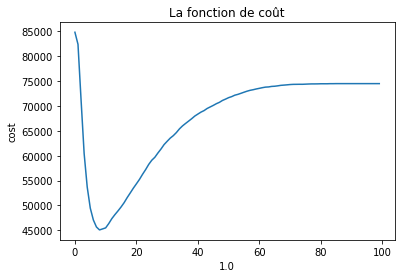

In [26]:
plt.plot(cost_function)
plt.xlabel(i)
plt.ylabel('cost')
plt.title('La fonction de coût')
plt.show()

In [27]:
arr = np.array(cost_function)

In [28]:
min_i = arr.argmin(axis=0)

In [29]:
min_i

8

Donc : min_i = 0.08

In [30]:
y_pred1 = np.where(y_prob>0.08, 1, 0)

In [31]:
from sklearn.metrics import classification_report

print(classification_report(y2_test, y_pred1))

              precision    recall  f1-score   support

         0.0       0.97      0.72      0.83     84805
         1.0       0.18      0.71      0.29      7448

    accuracy                           0.72     92253
   macro avg       0.57      0.72      0.56     92253
weighted avg       0.90      0.72      0.78     92253



In [32]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y2_test, y_pred1)
print(cm)

[[61293 23512]
 [ 2164  5284]]


In [33]:
f_score1 = f1_score(y2_test, y_pred1, average='binary')
print(f_score1)

0.29157929588345655


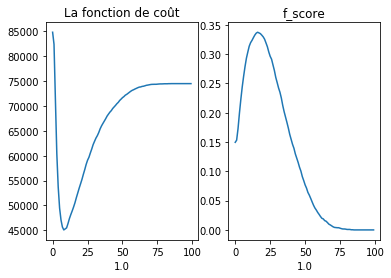

In [34]:
plt.subplot(121),
plt.plot(cost_function),
plt.xlabel(i)
plt.title('La fonction de coût')
plt.subplot(122),
plt.plot(score),
plt.xlabel(i),
plt.title('f_score'),
plt.show()

### Importance des fonctionnalités

In [35]:
X2= df.drop(['TARGET','SK_ID_CURR','index',  'Unnamed: 0'], axis=1)
feature_list = list(X2.columns)
# Get numerical feature importances
importances = list(lg.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(X, round(importance, 2)) for X, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: ENTRANCES_MODE       Importance: 232
Variable: EXT_SOURCE_2         Importance: 232
Variable: EXT_SOURCE_1         Importance: 210
Variable: ANNUITY_INCOME_PERC  Importance: 205
Variable: COMMONAREA_MODE      Importance: 151
Variable: Unnamed: 0           Importance: 137
Variable: DAYS_EMPLOYED        Importance: 106
Variable: APPROVED_DAYS_DECISION_MEAN Importance: 103
Variable: ACTIVE_DAYS_CREDIT_MIN Importance: 92
Variable: INSTAL_AMT_PAYMENT_SUM Importance: 88
Variable: INSTAL_AMT_PAYMENT_MEAN Importance: 85
Variable: AMT_ANNUITY          Importance: 83
Variable: DAYS_BIRTH           Importance: 82
Variable: DAYS_LAST_PHONE_CHANGE Importance: 81
Variable: INCOME_PER_PERSON    Importance: 80
Variable: PREV_DAYS_DECISION_MEAN Importance: 75
Variable: INSTAL_DPD_MAX       Importance: 74
Variable: ACTIVE_DAYS_CREDIT_VAR Importance: 71
Variable: DAYS_ID_PUBLISH      Importance: 65
Variable: DAYS_EMPLOYED_PERC   Importance: 63
Variable: POS_MONTHS_BALANCE_MEAN Importance: 62
Va

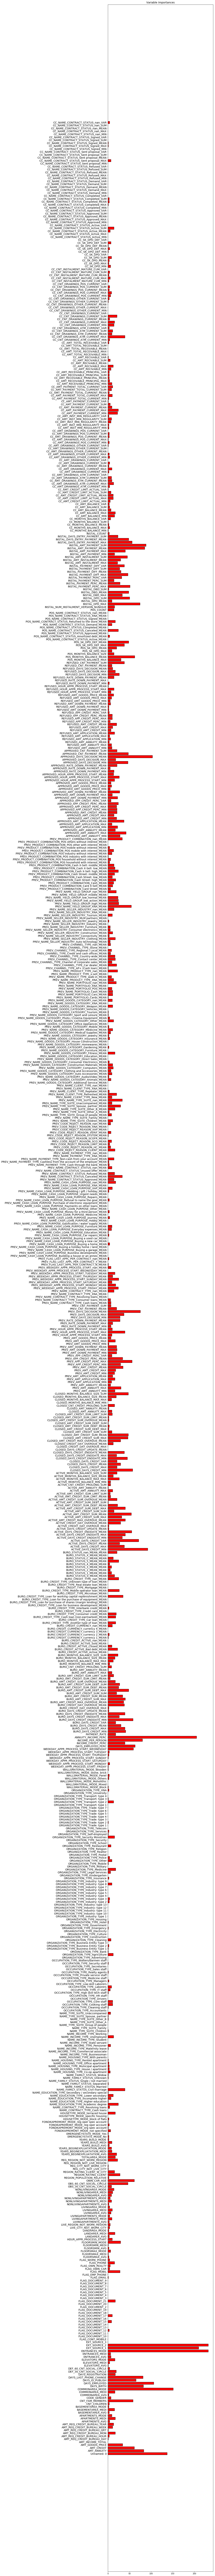

In [36]:
x_values = list(range(len(importances)))
fig, ax = plt.subplots(figsize=(10, 250))
# Make a bar chart
plt.barh(x_values, importances,  color = 'r', edgecolor = 'k', linewidth = 1.2)
# Tick labels for y axis
plt.yticks(x_values, feature_list,fontsize = 14)

plt.title('Variable Importances', fontsize = 14);

In [43]:
X2= df.drop(['TARGET','SK_ID_CURR','index', 'Unnamed: 0'], axis=1)
feature_list = list(X2.columns)
# Get numerical feature importances
importances = list(lg.feature_importances_)

# Extract feature importances

feature_importances_domain = pd.DataFrame({'feature': feature_list, 'importance': importances})


In [44]:
df2 = feature_importances_domain.sort_values(by=['importance'], ascending=False)

In [45]:
df2.shape

(795, 2)

In [46]:
df2

,feature,importance
37,EXT_SOURCE_3,232
35,EXT_SOURCE_1,232
36,EXT_SOURCE_2,210
244,PAYMENT_RATE,205
22,DAYS_BIRTH,151
...,...,...
604,REFUSED_RATE_DOWN_PAYMENT_MEAN,0
220,ORGANIZATION_TYPE_Transport: type 1,0
39,FLAG_DOCUMENT_10,0
219,ORGANIZATION_TYPE_Trade: type 7,0


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text xticklabel objects>)

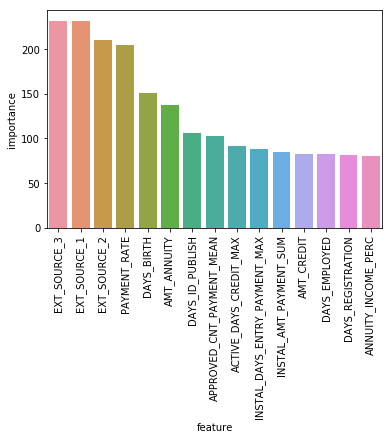

In [47]:
import seaborn as sns
ax = sns.barplot(x="feature", y="importance", data=df2.head(15))
plt.xticks(rotation='vertical')

In [48]:
df2.to_csv(r'D:\Documents\P7\feature_importances.csv')